# Tutorial Five: Principle Component Regression

## 实验前的准备

本次实验我们载入一些Python的安装包，如下：

In [28]:
from sklearn.datasets import load_diabetes

import os

import pandas as pd
import numpy as np
import random
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing # Data Preprocessing
import statsmodels.api as sm # LSE, Ridge Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 
from statsmodels.multivariate.pca import PCA # PCR

设置数据目录，如下：

In [29]:
os.chdir("/Users/lyuni/ECNU_DaSE/Courses/Stat_ML/Experiment/Data")

在本次实验中，所使用的数据集是

In [30]:
Data = pd.read_csv("Data_4.csv")
print(Data.head())

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    315    81      7    24   38     39     14    3449    835      69    321   
1    479   130     18    66   72     76      3    1624    457      63    224   
2    496   141     20    65   78     37     11    5628   1575     225    828   
3    321    87     10    39   42     30      2     396    101      12     48   
4    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks  PutOuts  Assists  Errors  Salary  
0   414     375      632       43      10   475.0  
1   266     263      880       82      14   480.0  
2   838     354      200       11       3   500.0  
3    46      33      805       40       4    91.5  
4   336     194      282      421      25   750.0  


我们可以了解这个数据集的样本量、特征维度等特征，如下：

In [31]:
p = Data.shape[1]-1
n = Data.shape[0]

print("The number of features is",p)
print("The sample size is",n)

The number of features is 16
The sample size is 263


## 背景

本次数据来自于1986年至1987年间美国职业棒球大联盟。这个数据记录了263名大联盟的选手所采集的收入数据及其历史棒球运动的表现。

## 数据
在本次数据中，共有17个变量（1个响应变量与16个自变量），具体如下表所示：

<table width = c(100,800,700), center = True>
    <tr>
        <td> 变量名                  </td>
        <td> 英文变量含义                 </td>
        <td> 中文变量含义                 </td>
    </tr>
    <tr>
        <td> AtBat                          </td>
        <td> Number of times at bat in 1986 </td>
        <td> 1986年间轮到击球的次数            </td>
    </tr>
    <tr>
        <td> Hits                         </td>
        <td> Number of hits in 1986       </td>
        <td> 1986年间击中球的次数           </td>
    </tr>
    <tr>
        <td> HmRun                         </td>
        <td> Number of home runs in 1986   </td>
        <td> 1986年间全垒打的次数             </td>
    </tr>
     <tr>
        <td> Runs                              </td>
        <td> Number of runs in 1986            </td>
        <td> 1986年间得分的次数                   </td>
    </tr>
    <tr>
        <td> RBI                               </td>
        <td> Number of runs batted in in 1986  </td>
        <td> 1986年间打者打点的次数                   </td>
    </tr>
    <tr>
        <td> Walks                               </td>
        <td> Number of walks in 1986  </td>
        <td> 1986年间打击手被保送的次数                   </td>
    </tr>
    <tr>
        <td> Years                               </td>
        <td> Number of years in the major leagues  </td>
        <td> 在大联盟的年限                  </td>
    </tr>
     <tr>
        <td> CAtBat                               </td>
        <td> Number of times at bat during his career  </td>
        <td> 在其棒球职业生涯中轮到击球的次数                 </td>
    </tr>
    <tr>
        <td> CHits                              </td>
        <td> Number of hits during his career  </td>
        <td> 在其棒球职业生涯中击中球的次数                 </td>
    </tr>
    <tr>
        <td> CHmRun                              </td>
        <td> Number of home runs during his career  </td>
        <td> 在其棒球职业生涯中全垒打的次数                 </td>
    </tr>
    <tr>
        <td> CRuns                              </td>
        <td> Number of runs during his career  </td>
        <td> 在其棒球职业生涯中得分的次数                 </td>
    </tr>
    <tr>
        <td> CRBI                              </td>
        <td> Number of runs batted in during his career  </td>
        <td> 在其棒球职业生涯中打者打点的次数                 </td>
    </tr>
    <tr>
        <td> CWalks                              </td>
        <td> Number of walks during his career  </td>
        <td> 在其棒球职业生涯中打击手被保送的次数                 </td>
    </tr>
    <tr>
        <td> PutOuts                              </td>
        <td> Number of put outs in 1986  </td>
        <td> 在1986年间接杀的次数                 </td>
    </tr>
    <tr>
        <td> Assists                             </td>
        <td> Number of assists in 1986  </td>
        <td> 在1986年间助杀的次数                 </td>
    </tr>
    <tr>
        <td> Errors                            </td>
        <td> Number of errors in 1986          </td>
        <td> 在1986年间失误的次数                 </td>
    </tr>
    <tr>
        <td> Salary                            </td>
        <td> 1987 annual salary on opening day in thousands of dollars          </td>
        <td> 在1987年开业时年薪（单位：千美元）         </td>
    </tr>
</table>

## 任务

本次实验中，我们需要解决以下问题：

1. 如何利用主成分回归改进模型？
2. 主成分回归估计是否比最小二乘估计更优？

## 解决方案

在正式分析这个问题之前，我们介绍一下数据分析的基础步骤。
第一步：数据采集（问卷、爬虫、系统采集等方式）与数据清洗；
第二步：数据预处理（缺失、异常等，划分训练集和测试（验证）集）；
第三步：数据的探索性分析（计算简单的统计量、绘制基础图表）；
第四步：构建模型（针对所提出的问题，利用模型来解决）；
第五步：模型诊断（考虑所提出是否符合数据）；
第六步：得出结论（根据数据分析结果给出合理且科学的决策）。

在本次实验中，我们简化了前三步骤。在数据预处理中，需要划分训练集和测试集，常见的方法有：留出法（Hold-out）和$K$折交叉验证法（K-fold Cross Validation）。我们这里介绍留出法，具体如下：

在留出法中，需要划分两个数据集——训练集和测试集。

第一，需要确定两个数据集的样本量。通常按一定比例，如8:2。

In [32]:
n_train = 210 # 80% instances used for training
n_test = n-n_train

第二，在所有样本中随机选取。这里我们固定随机种子，优势是：这样的划分是相对确定性的，有利于在编程过程中反复验证结果是否正确。

In [33]:
seed = 1
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()

第三，我们根据所确定的索引将数据划分为两个数据集。

In [34]:
Data_train = Data.loc[index_selected]
Data_test = Data.drop(index = index_selected)

在数据预处理中，除了划分训练集和测试集之外，我们还需要根据模型重新构建数据类型。比如在回归模型中，将响应变量和特征拆分为两个部分，即

In [35]:
## Pre-processing
X_train = Data_train.drop(columns = ['Salary'],axis = 1)
Y_train = Data_train.Salary
X_test = Data_test.drop(columns = ["Salary"],axis=1)
Y_test = Data_test.Salary

在分析多重共线性时，我们需要将数据进行**标准化**。

在数据$\{(y_i,\mathbf{x}_i):i=1,2,\cdots,n\}$，其中，$\mathbf{x}_i = (x_{i1},x_{i2},\cdots,x_{ip})'$，传统的标准化指的是
$$
x_{ij}^{\ast} = \frac{x_{ij}-\bar{x}_j}{\sqrt{\frac{1}{n-1} \sum_{i=1}^n (x_{ij} - \bar{x}_j)^2}}
$$
注：这里分母中的方差通常用样本方差（即前面的系数为$(n-1)^{-1}$），也有使用总体方差（即前面的系数为$(n)^{-1}$）。在$n$很大时，分母上方差无明显差异。传统的标准化指的是：使得均值为0、方差为1。

而在本实验中，我们所定义的**标准化**为
$$
x_{ij}^{\ast} = \frac{x_{ij}-\bar{x}_j}{\sqrt{\sum_{i=1}^n (x_{ij} - \bar{x}_j)^2}}
$$
这里与传统的标准化相差一个常数。

In [36]:
X_train_standardized = preprocessing.scale(X_train, with_mean = True, with_std=True)/np.sqrt(n_train)
Y_train_centered = preprocessing.scale(Y_train, with_mean = True, with_std=False)
Y_train_mean = np.average(Y_train)
X_test_standardized = preprocessing.scale(X_test, with_mean = True, with_std=True)/np.sqrt(n_test)

这里有一个问题值得注意：关于测试数据的标准化，对于测试数据而言，其标准化的方式仅仅只能利用可以观测到的数据，不能使用需要**未知**信息。在回归问题中，这样进行标准化是可行的，因为在测试集中特征是可观测到的，才能通过这些特征来进行预测，所以这种方法是可行的。如果是在时间序列等场景，一定需要注意，不要利用未来的信息做数据预处理，这样是不正确的。

### Task 1: 构建主成分回归

第一步，对数据进行主成分分析。

问题：什么是主成分呢？

以下我们先介绍主成分分析的基本想法。对于$p$维随机向量$\mathbf{x} = (x_1,x_2,\cdots,x_p)'$，假定
- 其均值向量为$E(\mathbf{x}) = \mathbf{\mu}$;
- 其方差-协方差矩阵$Var(\mathbf{x}) = \Sigma$.
我们所提取的主成分实际上是$p$维随机向量$\mathbf{x}$的$p$个线性组合，即

$$
\begin{cases}
z_1 = \mathbf{a}_1' \mathbf{x} = a_{11}x_1 + a_{21}x_2 + \cdots+a_{p1}x_p\\
z_2 = \mathbf{a}_2' \mathbf{x} = a_{12}x_1 + a_{22}x_2 + \cdots+a_{p2}x_p\\
\vdots\\
z_p = \mathbf{a}_p' \mathbf{x} = a_{1p}x_1 + a_{2p}x_2 + \cdots+a_{pp}x_p\\
\end{cases}
$$

根据概率论的知识可知，$Var(z_i) = \mathbf{a}_i' \Sigma \mathbf{a}_i$ 以及 $Cov(z_i,z_j) = \mathbf{a}_i' \Sigma \math{a}_j$。

如何确定$\mathbf{a}_i,i=1,2,\cdots,p$？它们需要满足
- $\mathbf{a}_i'\mathbf{a}_i = 1$；
- 当$i>1$时，$\mathbf{a}_i'\Sigma\mathbf{a}_j = 0$；
-$\mathbf{a_i} = \arg\max_{\mathbf{a}'\mathbf{a} = 1, \mathbf{a}'\Sigma\mathbf{a}_j,j=1,2,\cdots,i-1} Var(\mathbf{a}'\mathbf{x})$；

如何求解？对于$\mathbf{a}_1 = (a_{11},a_{21},\cdots,a_{p1})'$满足
$$
\mathbf{a}_1 = \arg\max_{\mathbf{a}} \mathbf{a}'\mathbf{x} \quad \text{s.t.} \quad \mathbf{a}_1'\mathbf{a}_1 = 1.
$$
我们采用拉格朗日乘子法，令
$$
l(\mathbf{a}_1) = Var(\mathbf{a}_1'\mathbf{x}) - \lambda(\mathbf{a}_1'\mathbf{a}_1 - 1) = \mathbf{a}_i'\Sigma\mathbf{a}_i - \lambda (\mathbf{a}_1'\mathbf{a}_1-1)
$$
关于$l(\mathbf{a}_1) $对$\mathbf{a}_1$求导，即
$$
\begin{cases}
\frac{\partial l}{\partial \mathbf{a}_1} = 2(\Sigma - \lambda I) \mathbf{a}_1 = 0\\
\frac{\partial l}{\partial \lambda} = \mathbf{a}_1'\mathbf{a}_1 - 1 = 0
\end{cases}
$$
于是，$\Sigma \mathbf{a}_1 = \lambda \mathbf{a}_1$，由此可知，$\lambda$是$\Sigma$的特征值，而$\mathbf{a}_1$是该特征值对应的特征向量。

因此，我们对$Var(\mathbf{x}) = \Sigma$求特征值和特征向量，即
- $\Sigma$的特征值$\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_p \geq 0$.
- $\mathbf{a}_1,\mathbf{a}_2,\cdots,\mathbf{a}_p$为相应的单位正交特征向量。所以，$\mathbf{x}$的第$i$个主成分为
$$
z_{i} = \mathbf{a}_i'\mathbf{x}, i=1,2,\cdots,p.
$$

在实际数据中，如果某一个随机变量的方差过大，会导致主成分的权重会向方差大的随机变量倾斜，那么所构造的主成分是不合理的。于是，采用随机变量$\mathbf{x}$的相关阵$Corr(\mathbf{x})$来代替方差-协方差矩阵$\Sigma$.

In [37]:
model_pca = PCA(X_train_standardized,standardize = False, demean = True)
model_pca_cr = model_pca.eigenvals # contribution rate of each component
print("The percentages of total variance are", np.around(model_pca_cr,4))

The percentages of total variance are [7.2985e+00 3.9851e+00 1.7352e+00 9.1210e-01 6.8070e-01 5.5120e-01
 2.6490e-01 1.8050e-01 1.2800e-01 1.0050e-01 6.0000e-02 5.3300e-02
 2.8200e-02 1.6100e-02 4.4000e-03 1.3000e-03]


以上计算的就是$\mathbf{X}'\mathbf{X}$的特征值，也被称为每个主成分的贡献率。通过以下代码可以进行验证。

In [38]:
Corr_Mat = X_train_standardized.T @ X_train_standardized
Lambda, V = np.linalg.eig(Corr_Mat)
Lambda = sorted(Lambda,reverse = True)
print("The eigen values of X'X are ", np.around(Lambda,4))

The eigen values of X'X are  [7.2985e+00 3.9851e+00 1.7352e+00 9.1210e-01 6.8070e-01 5.5120e-01
 2.6490e-01 1.8050e-01 1.2800e-01 1.0050e-01 6.0000e-02 5.3300e-02
 2.8200e-02 1.6100e-02 4.4000e-03 1.3000e-03]


在主成分分析中，主成分个数也是一个超参数。如何选择主成分的个数也是一个重要的问题。

在主成分分析中，我们可以绘制scree plot来作出主成分个数的主观判断。

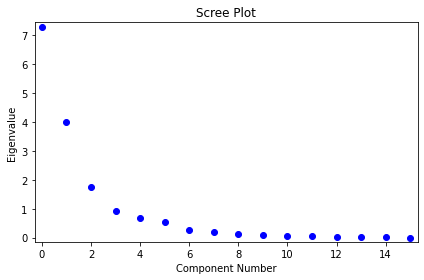

In [39]:
fig = model_pca.plot_scree(log_scale = False)

除此之外，我们还可以计算每增加一个主成分后，对信息**增量**是多少？我们可以计算累积贡献率。

In [40]:
model_pca_ccr = np.cumsum(model_pca_cr)/p # cummulative contribution rate
print("The cummulative percentages of total variance are", np.around(model_pca_ccr,4))

The cummulative percentages of total variance are [0.4562 0.7052 0.8137 0.8707 0.9132 0.9477 0.9642 0.9755 0.9835 0.9898
 0.9935 0.9969 0.9986 0.9996 0.9999 1.    ]


我们选取主成分时需要其累积贡献率达到90%，即

In [41]:
pca_cv = 0.90

In [42]:
num_pca = np.min(np.where(model_pca_ccr > pca_cv))
print("The appropriate number of component is", (num_pca+1))

The appropriate number of component is 5


第二步，我们利用所提取的主成分构建线性回归模型。具体来说，$\mathbf{X}$是已标准化的设计矩阵。假定$\mathbf{X}'
\mathbf{X}$的特征值$\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_p$和其相应单位正交化后的特征向量为$\mathbf{v}_1,\mathbf{v}_2,\cdots,\mathbf{v}_p$.令
$$
\Lambda = \text{diag}\{\lambda_1,\lambda_2,\cdots,\lambda_p\},\quad 
V' = (\mathbf{v}_1, \mathbf{v}_2,\cdots,\mathbf{v}_p)
$$
于是，我们所构建的主成分为
$$
Z = X V'
$$
在线性回归模型中
$$
\mathbf{y} = X\mathbf{\beta} + \mathbf{\epsilon} = X V'V \mathbf{\beta} + \mathbf{\epsilon} = Z \mathbf{\alpha} + \mathbf{\epsilon} 
$$
我们选取前$k$个主成分作为特征构建线性回归模型，即
$$
\mathbf{y} = Z_1 \mathbf{\alpha}_1 + \mathbf{\epsilon}
$$
其中，$Z = (\mathbf{z}_1,\mathbf{z}_2,\cdots,\mathbf{z}_{k},\mathbf{z}_{k+1},\cdots,\mathbf{z}_p) = (Z_1,Z_2)$而
$\mathbf{\alpha} = (\alpha_1,\alpha_2,\cdots,\alpha_k,\alpha_{k+1},\cdots,\alpha_p)' = (\mathbf{\alpha}_1',\mathbf{\alpha}_2')'$.

我们用最小二乘估计来估计$\mathbf{\alpha}_1$即
$$
\hat{\mathbf{\alpha}_1} = (Z_{1}'Z_{1})^{-1}Z_{1}'\mathbf{y}.
$$
而用零来估计$\mathbf{\alpha}_2 = \mathbf{0}$。所以，$\hat{\mathbf{\alpha}} = (\hat{\mathbf{\alpha}_1}',\mathbf{0}')$

In [43]:
model_pca_selected = PCA(X_train_standardized,  standardize = False,  demean = True)
V = model_pca_selected.loadings
Z_train_standardized= X_train_standardized @ V[:,0:(num_pca+1)]
model_pcr = sm.OLS(Y_train_centered, Z_train_standardized).fit()

第三，在通过线性变换，来估计主成分回归中的参数。具体来说，回归系数$\mathbf{\beta}$的主成分估计为
$$
\hat{\mathbf{\beta}}_{pcr} = V' \hat{\mathbf{\alpha}}
$$

In [44]:
model_pcr_coef = V.T @ np.pad(model_pcr.params,(0,p-(num_pca+1)))
print("The regression coefficients in PCR are", np.around(model_pcr_coef,4))

The regression coefficients in PCR are [   29.3117  -132.0506  -249.3543  -106.9957  -207.9692  -376.854
    85.6962  -316.6594  -218.0032   122.9863  1130.1306 -1116.7174
   621.7523  -241.2335  -233.2593    42.4857]


### Task 2: 比较主成分回归估计与最小二乘估计

这里我们采用测试集的RMSE来比较两种估计方法的优劣。

In [47]:
model_ols = sm.OLS(Y_train_centered,X_train_standardized).fit()
model_ols_coef = model_ols.params 
Y_pred_ols = Y_train_mean + X_test_standardized @ model_ols_coef
ols_rmse = np.sqrt(np.mean((Y_pred_ols-Y_test)**2))

Y_pred_pcr = Y_train_mean + X_test_standardized @ model_pcr_coef
pcr_rmse = np.sqrt(np.mean((Y_pred_pcr-Y_test)**2))

print("The RMSE in the ordinary regression is", round(ols_rmse,4))
print("The RMSE in the principal component regression is",round(pcr_rmse,4))



The RMSE in the ordinary regression is 591.1203
The RMSE in the principal component regression is 566.4681
